In [7]:
import numpy as np
import pandas as pd
import yfinance as yf

In [129]:
sectors= ['VOO','TLT','SLV','ENVX','NKE','OSCR','SNOW','AMD','BA','PYPL','SLB','HIMS']
sectors = ['VOO','SPY']

data = yf.download(sectors, start= '2022-01-01', end= '2025-02-14')['Close']
data.head()

[*********************100%***********************]  2 of 2 completed


Ticker,SPY,VOO
Date,,
2022-01-03,457.181610,419.652863
2022-01-04,457.028473,419.480896
2022-01-05,448.252533,411.446045
2022-01-06,447.831421,410.891998
2022-01-07,446.060974,409.468414


In [131]:
# Returns
returns = data.pct_change().dropna()
returns.head()

Ticker,SPY,VOO
Date,,
2022-01-04,-0.000335,-0.000410
2022-01-05,-0.019202,-0.019154
2022-01-06,-0.000939,-0.001347
2022-01-07,-0.003953,-0.003465
2022-01-10,-0.001244,-0.001307


In [133]:
portfolio_stats = pd.DataFrame(returns.mean(),columns=['Mean_Return'])
portfolio_stats['Weight'] = 1/len(sectors)
portfolio_stats.head()

,Mean_Return,Weight
Ticker,,
SPY,0.000428,0.5
VOO,0.000430,0.5


In [135]:
covariance_matrix = returns.cov()
covariance_matrix

Ticker,SPY,VOO
Ticker,,
SPY,0.000119,0.000119
VOO,0.000119,0.000119


In [137]:
simulations = 1_000
days = len(data.index.unique())
initial_capital=100_000

portfolio = np.zeros((days, simulations))

historical_returns = np.full(
    shape=(days, len(sectors)),
    fill_value=portfolio_stats['Mean_Return']
)

In [139]:
# Create a lower-triangular matrix (L) from our covariance matrix
L = np.linalg.cholesky(covariance_matrix)

for i in range(0, simulations):
    Z = np.random.normal(size=(days, len(sectors)))
    daily_returns = historical_returns + np.dot(L,Z.T).T
    portfolio[:, i] = (np.cumprod(np.dot(daily_returns, portfolio_stats['Weight']) +1) * initial_capital
                      )

simulated_portfolio = pd.DataFrame(portfolio)

In [141]:
alpha = 5

# VaR (% certain we will have atleast this value)
def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)

# Average loss if we go below the VaR
def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()

def expected_return():
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val.mean()

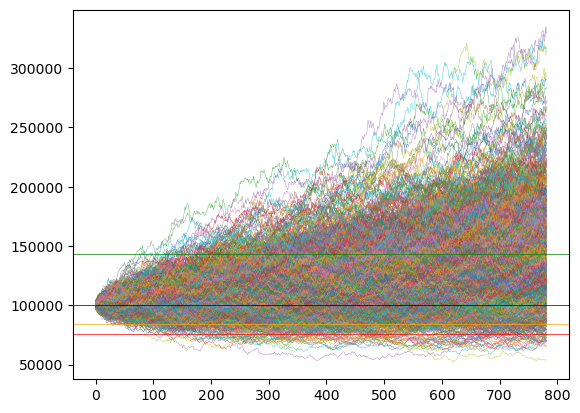

In [143]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
exp_ret = expected_return()

ax = simulated_portfolio.plot(lw= 0.25, legend= False)
ax.axhline(mc_var, lw= 0.5, c= 'orange')
ax.axhline(cond_var, lw= 0.5, c= 'red')
ax.axhline(initial_capital, lw= 0.5, c= 'black')
ax.axhline(exp_ret, lw= 0.5, c= 'green')

In [144]:
print(f"Expected Portfolio Value: ${exp_ret:,.2f}")
print(f"Value at Risk (95% Confidence): ${mc_var:,.2f}")
print(f"Expected Shortfall (Conditional VaR): ${cond_var:,.2f}")

Expected Portfolio Value: $143,538.43
Value at Risk (95% Confidence): $83,833.70
Expected Shortfall (Conditional VaR): $75,849.99
